In [1]:
import json
from datetime import date
from datetime import datetime
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine
import os

In [2]:
app_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:

with open(os.path.join(app_dir,'config'+'\\config.json'), "r") as f:
  config = json.load(f)

direccion_base_datos = config["config_base"]["directorio_aplicacion"]  + \
                        config["config_base"]["directorio_basedatos"] + \
                        config["config_base"]["base_datos"]

In [4]:
direccion_base_datos

'D:/projects/milk_forecast/data/db_datos_modelos.db'

In [5]:
# ***** Copia informacion a base de datos *****
engine = create_engine("sqlite:///"+direccion_base_datos)

# Borra tabla anterior 
connection = engine.raw_connection()
cursor = connection.cursor()
command = "SELECT * FROM recoleccion_nacional_leche;"

cursor.execute(command)

recoleccion_leche_df = pd.DataFrame(cursor.fetchall(), columns=["region", "fecha", "litros", "departamento", "cod_depto", "precio"])
connection.close()

recoleccion_leche_df["fecha"] = pd.to_datetime(recoleccion_leche_df["fecha"], format="%Y-%m-%d")


In [6]:

#aggregate recoleccion_leche_df by fecha and calculate weighted mean of precio by litros and total litros
recoleccion_mensual = recoleccion_leche_df.groupby("fecha").agg({"litros": "sum", 
                                                 "precio": lambda x: np.average(x, weights=recoleccion_leche_df.loc[x.index, "litros"])}).\
                                                    reset_index()

                                                    


In [7]:
# filter recoleccion_mensual by fecha after 2010-01-01 and befor 2023-01-01
recoleccion_mensual = recoleccion_mensual[(recoleccion_mensual["fecha"] >= "2010-01-01") & (recoleccion_mensual["fecha"] < "2023-01-01")].\
                        reset_index(drop=True)

In [8]:
recoleccion_mensual.info()
recoleccion_mensual.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   156 non-null    datetime64[ns]
 1   litros  156 non-null    float64       
 2   precio  156 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.8 KB


,fecha,litros,precio
151,2022-08-01,2.961690e+08,1943.740922
152,2022-09-01,2.762961e+08,1984.918055
153,2022-10-01,2.776623e+08,2073.325153
154,2022-11-01,2.633826e+08,2140.504647
155,2022-12-01,2.717809e+08,2218.388835


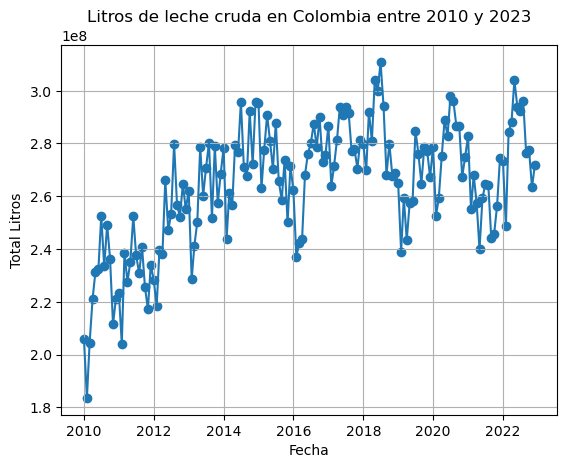

In [9]:
import matplotlib.pyplot as plt

plt.plot(recoleccion_mensual["fecha"], recoleccion_mensual["litros"], label="Litros recolectados")
plt.scatter(recoleccion_mensual["fecha"], recoleccion_mensual["litros"], )
plt.xlabel("Fecha")
plt.ylabel("Total Litros")
plt.title("Litros de leche cruda en Colombia entre 2010 y 2023")
plt.grid()
plt.show()


Descomponer la serie para identificar comportamientos estacionales y de tendencia.

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
plt.rcParams["figure.figsize"] = (10,3)

In [11]:
#set fecha as index
recoleccion_mensual = recoleccion_mensual.set_index("fecha")

In [12]:
descomposicion_litros_additive = seasonal_decompose(recoleccion_mensual['litros'], model='additive', period=12)
descomposicion_litros_multip = seasonal_decompose(recoleccion_mensual['litros'], model='multiplicative', period=12)

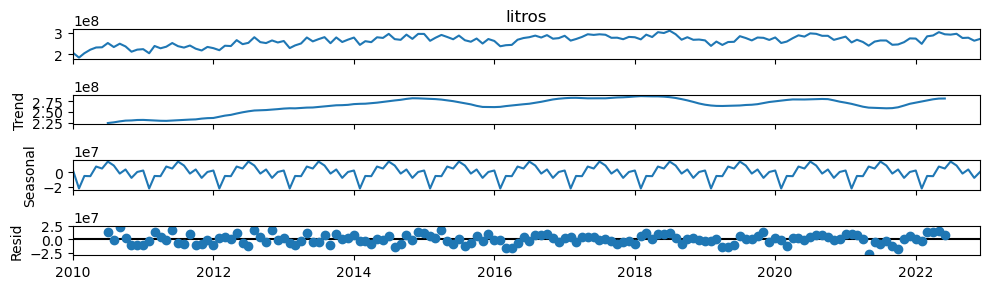

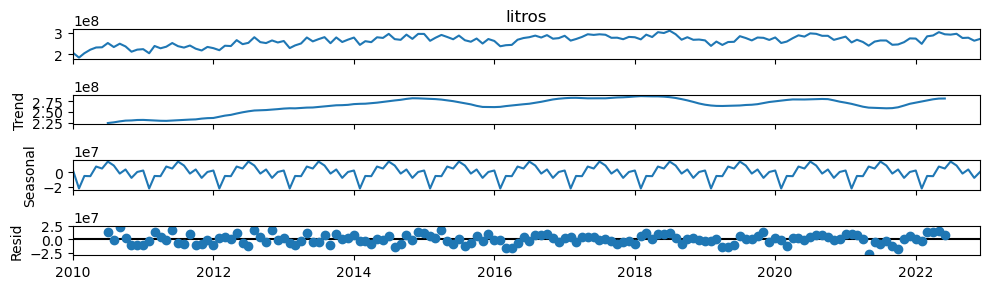

In [13]:
descomposicion_litros_additive.plot()

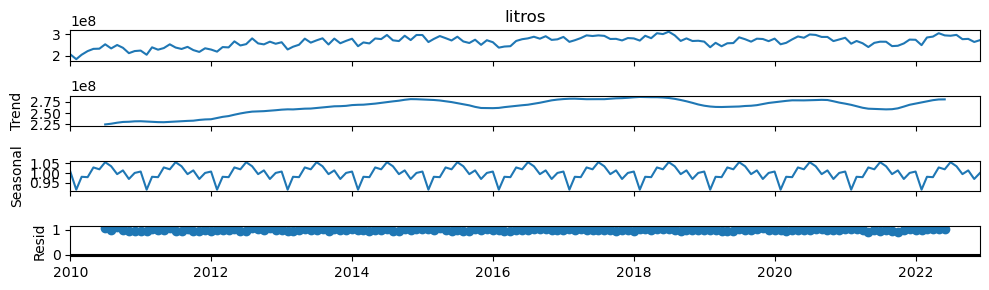

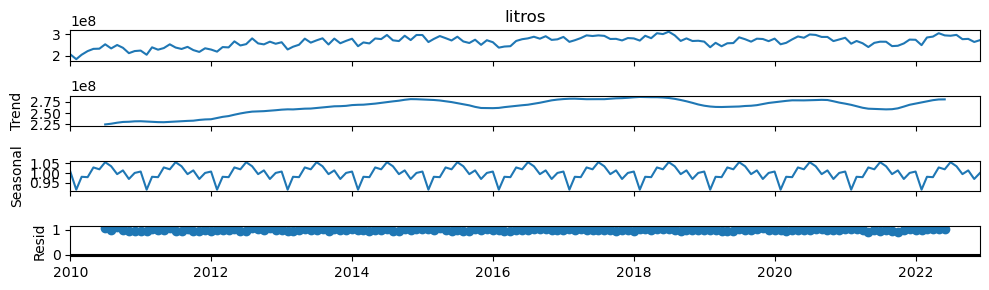

In [14]:
descomposicion_litros_multip.plot()

Identificar estacionariedad

In [15]:
from statsmodels.tsa.stattools import adfuller, kpss

In [16]:
def print_results(output, test='adf'):
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    decision = 'Non-Stationary'

    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
            
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'

    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value

    return pd.Series(output_dict, name=test)

In [17]:
adf_result_litros = adfuller(recoleccion_mensual["litros"], regression='ct')
print_results(adf_result_litros)


Test Statistic               -2.652334
p-value                       0.256402
Numbers of lags                     14
decision                Non-Stationary
Critical Value (1%)          -4.024454
Critical Value (5%)          -3.442098
Critical Value (10%)         -3.145593
Name: adf, dtype: object

In [18]:
kpss_result_litros = kpss(recoleccion_mensual["litros"], regression='ct')
print_results(kpss_result_litros, test='kpss')

C:\Users\augus\AppData\Local\Temp\ipykernel_28692\769611340.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result_litros = kpss(recoleccion_mensual["litros"], regression='ct')


Test Statistic                 0.318477
p-value                            0.01
Numbers of lags                       7
decision                 Non-Stationary
Critical Value (10%)              0.119
Critical Value (5%)               0.146
Critical Value (2.5%)             0.176
Critical Value (1%)               0.216
Name: kpss, dtype: object

Usar tecnicas de modelamiento univariado

In [19]:
import warnings
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product

In [20]:
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

Función para partir los datos en datos de entrenamiento y datos de prueba

In [21]:
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

def split_data_date(data, date_var, date_split):
    data = data.reset_index()

    train = data[data[date_var] <= datetime.strptime(date_split, "%Y-%m-%d")].set_index(date_var)
    test = data[data[date_var] > datetime.strptime(date_split, "%Y-%m-%d")].set_index(date_var)
    
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [22]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k

    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [23]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

In [24]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [25]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [39]:
train_data_df, test_data_df = split_data_date(recoleccion_mensual, "fecha", "2021-12-31")

train_data = train_data_df['litros']
test_data = test_data_df['litros']

train: 144 , test: 12


In [27]:
train_data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 144 entries, 2010-01-01 to 2021-12-01
Series name: litros
Non-Null Count  Dtype  
--------------  -----  
144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


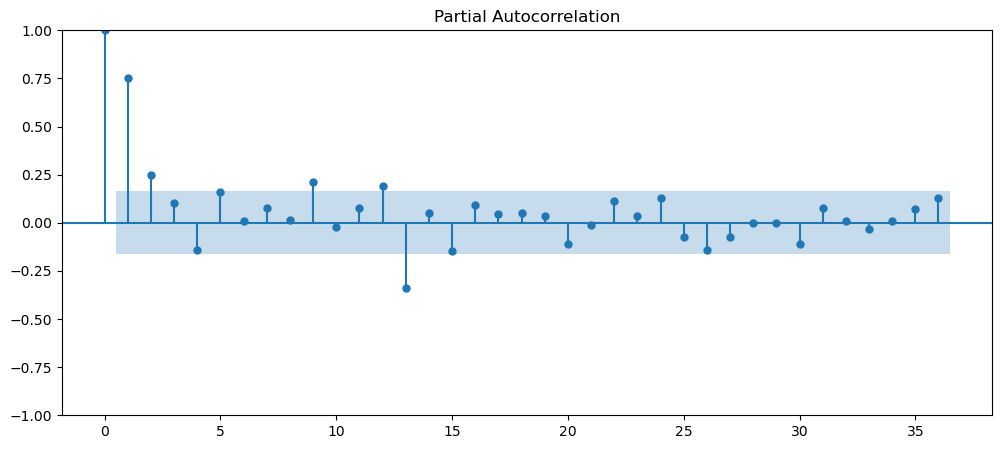

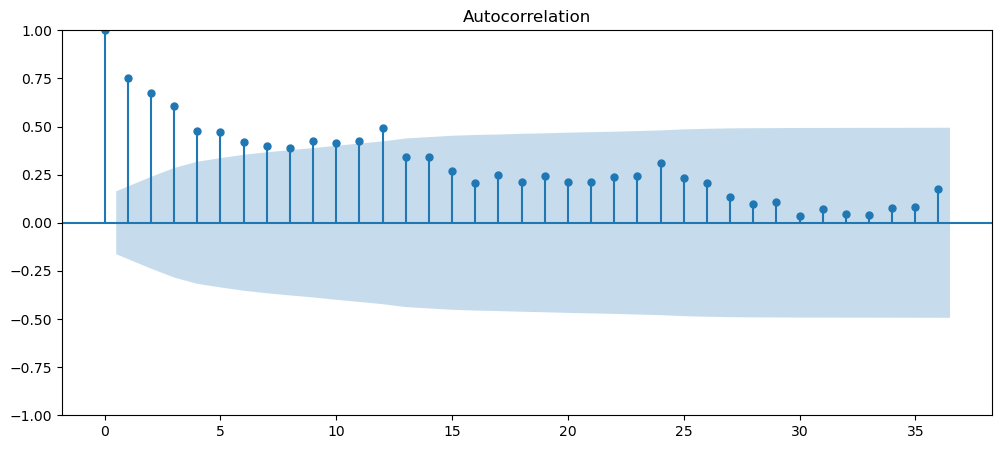

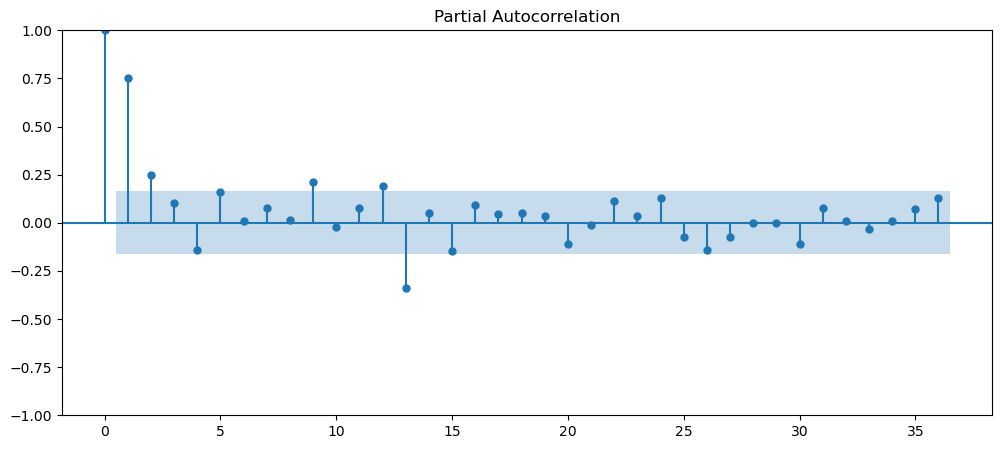

In [28]:
plot_acf(train_data, lags=36)
plot_pacf(train_data, lags=36)


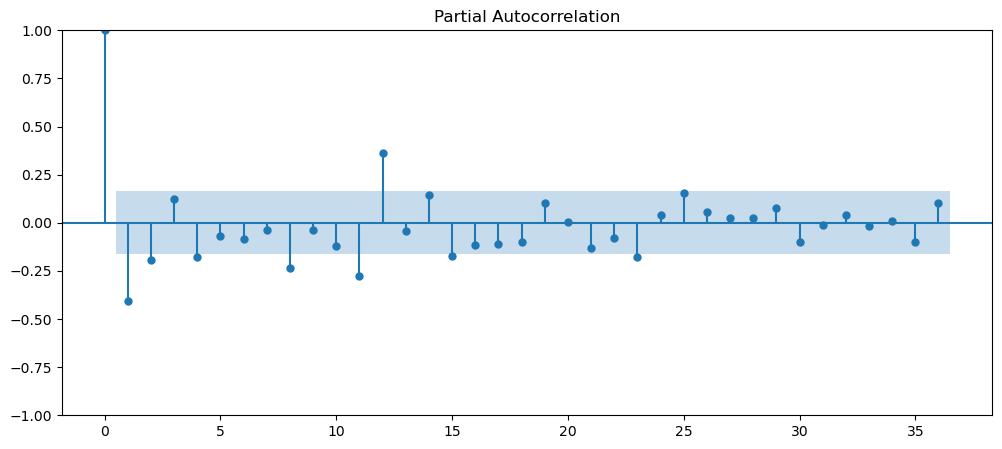

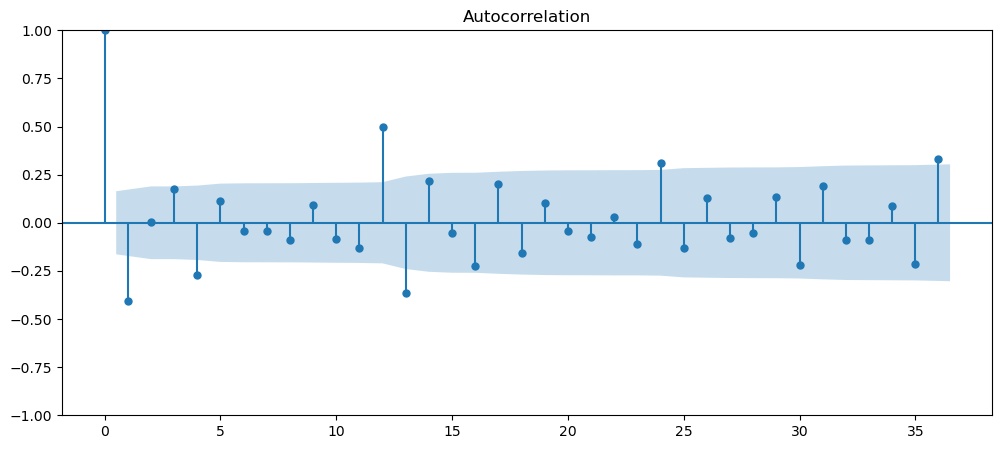

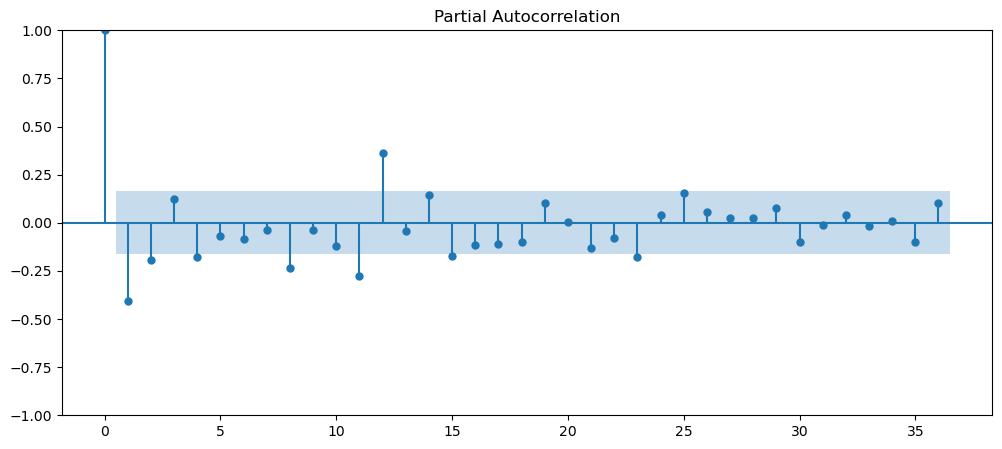

In [29]:
plot_acf(train_data.diff().dropna(), lags=36)
plot_pacf(train_data.diff().dropna(), lags=36)

Prueba forecast con Exponential smoothing

In [30]:
from statsmodels.tsa.api import ExponentialSmoothing

In [31]:
trend = ['add', 'mul']
damped = [True, False]
seasonal = ['add' , 'mul']
periods = [4, 6, 12]

parametros_exp_smooth = combinator([trend, damped, seasonal,periods])


In [32]:
train = train_data.values.ravel()
y = test_data.values.ravel()


In [33]:
score_exponential_smooth = {}

for i, (t, dp, seas, per) in enumerate(parametros_exp_smooth):
    exp = ExponentialSmoothing(train, trend=t, damped_trend=dp, seasonal= seas, seasonal_periods=per)

    model = exp.fit(use_brute=True, optimized=True)

    y_hat = model.forecast(len(y))
    
    score_exponential_smooth[i] = {'trend':t,
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic,
                'AICc':model.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [34]:
exp_smooth_best_model = get_best_model(score_exponential_smooth, 'MAPE')

Best model: 20 with lowest MAPE score: 0.03699616973047317


In [35]:
exp_smooth_best_model

In [36]:
exp_smooth_best_model.summary()

Dep. Variable:,endog,No. Observations:,144
Model:,ExponentialSmoothing,SSE,17651988072835676.000
Optimized:,True,AIC,4703.333
Trend:,Multiplicative,BIC,4750.850
Seasonal:,Additive,AICC,4708.805
Seasonal Periods:,12,Date:,"Sat, 07 Oct 2023"
Box-Cox:,False,Time:,13:35:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5353571,alpha,True
smoothing_trend,0.0001,beta,True


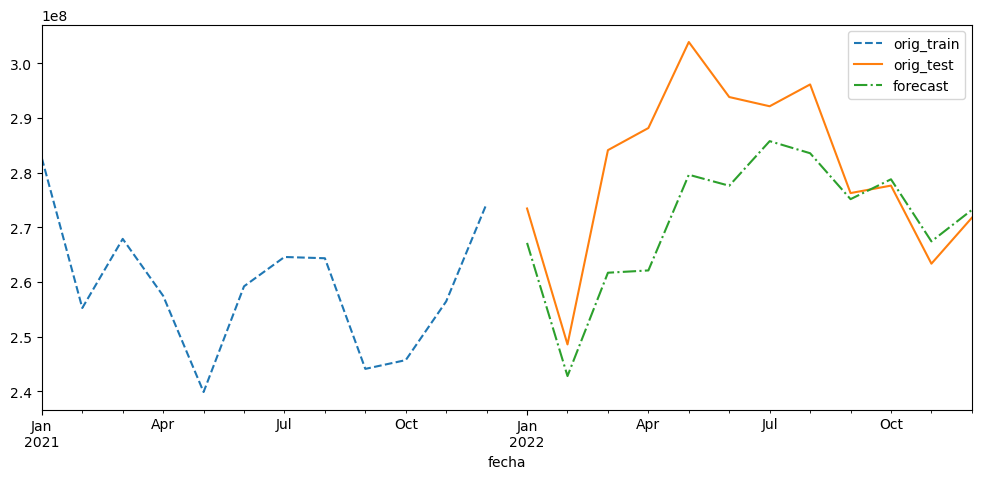

In [37]:
plot_forecast(exp_smooth_best_model, "2021-01-01", train_data, test_data)

Crear modelo SARIMAX automaticamente

In [38]:
import pmdarima as pm

In [40]:
auto_model = pm.auto_arima(train_data, seasonal = True, m = 12, stepwise=True)

In [41]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -2539.698
Date:                              Sat, 07 Oct 2023   AIC                           5095.396
Time:                                      13:38:57   BIC                           5119.099
Sample:                                  01-01-2010   HQIC                          5105.028
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2631      0.084    -14.986      0.000      -1.428      -1.098
ar.L2         -1.0970      0.099    -11.100      0.000      -1.291      -0.903
ar.L3         -0.0967      0.080     -1.210      0.226      -0.253       0.060
ma.L1          1.1255      0.027     40.978      0.000       1.072       1.179
ma.L2          0.9761      0.046     21.128      0.000       0.886       1.067
ar.S.L12       0.8526      0.097      8.833      0.000       0.663       1.042
ma.S.L12      -0.7068      0.127     -5.587      0.000      -0.955      -0.459
sigma2       1.89e+14   1.21e-16   1.57e+30      0.000    1.89e+14    1.89e+14
===================================================================================
Ljung-Box (L1) (Q):                   2.11   Jarque-Bera (JB):                 3.41
Prob(Q):                              0.15   Prob(JB):                         0.18
Heteroskedasticity (H):               0.63   Skew:                            -0.29
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.9e+45. Standard errors may be unstable.
"""

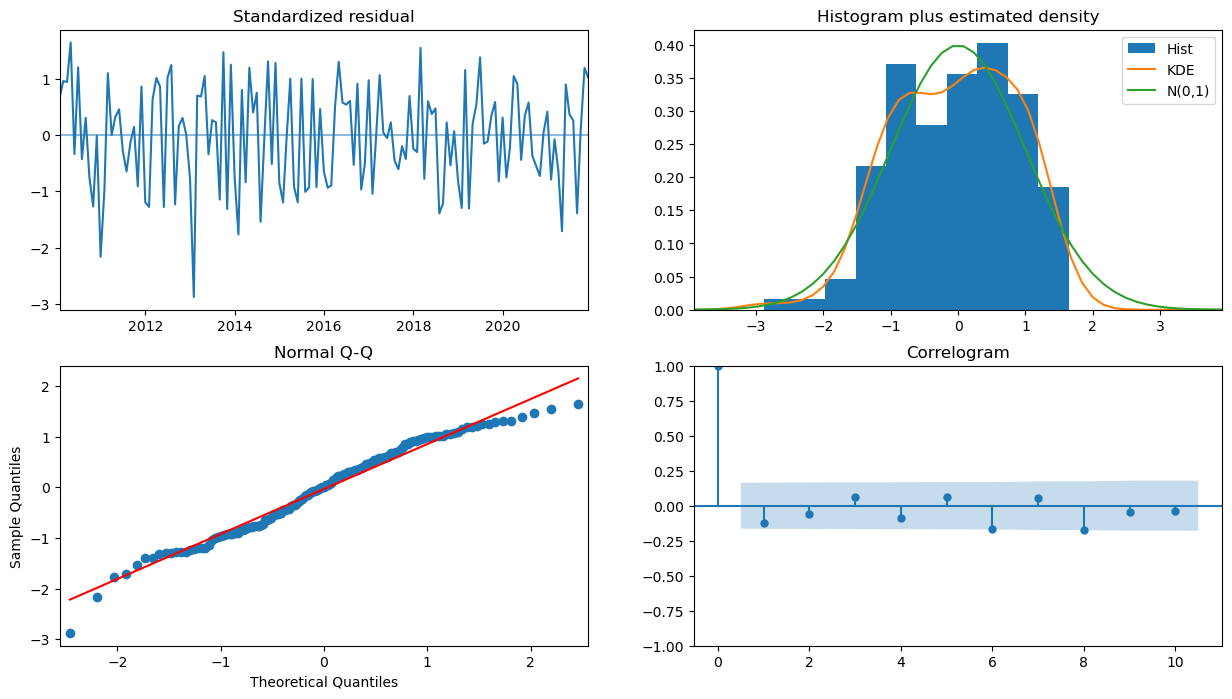

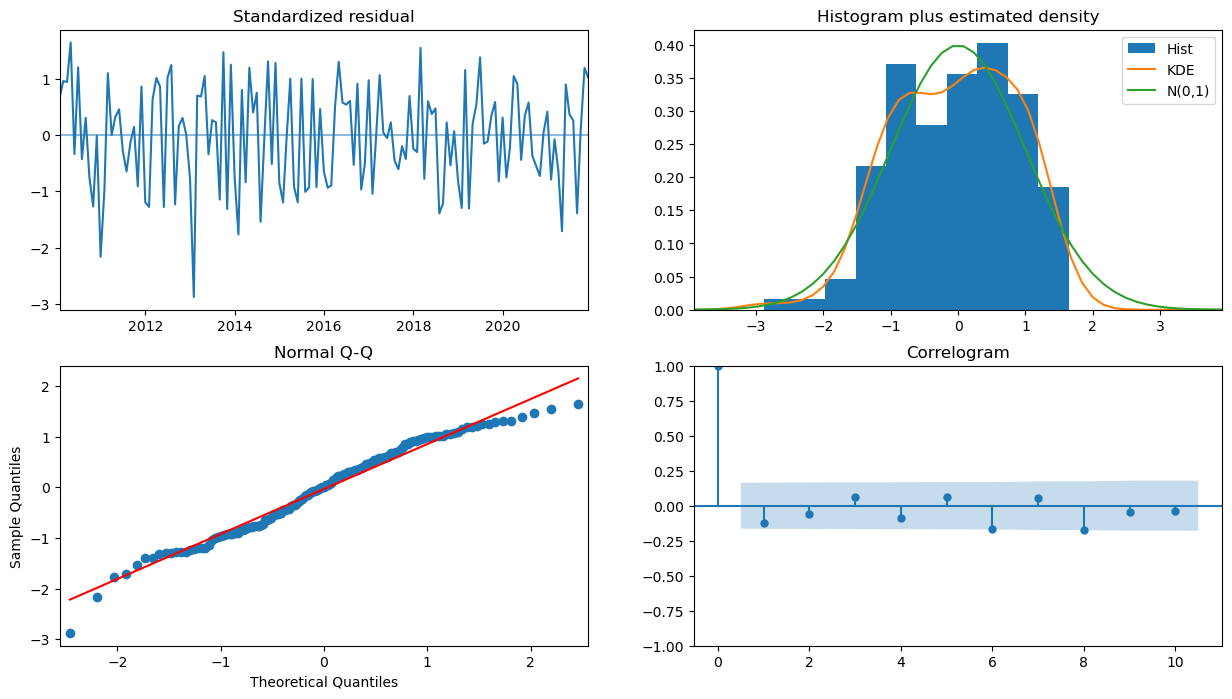

In [42]:
auto_model.plot_diagnostics(figsize=(15,8))

In [45]:
n = test_data.shape[0]
forecast_auto_arima, conf_interval_auto_arima = auto_model.predict(n_periods=n, return_conf_int=True)   
lower_ci_auto_arima, upper_ci_auto_arima = zip(*conf_interval_auto_arima)

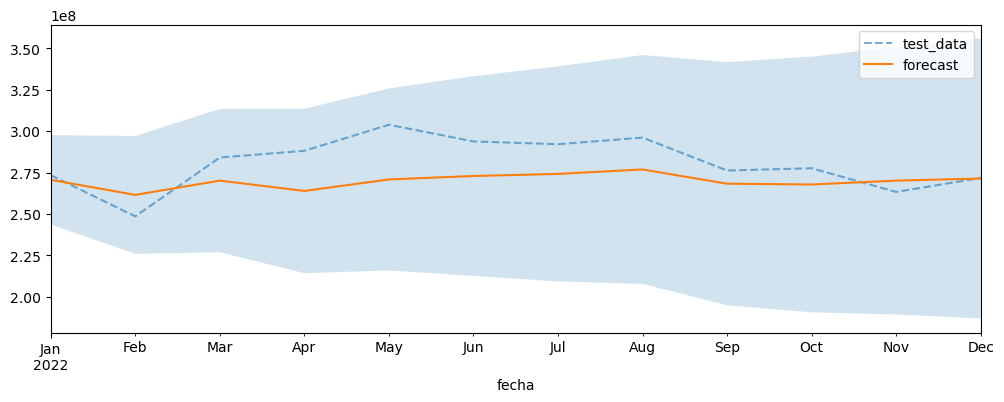

In [48]:
index = test_data.index
ax = test_data.plot(style='--', alpha=0.6, figsize=(12, 4))
pd.Series(forecast_auto_arima, index= index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci_auto_arima, upper_ci_auto_arima,  alpha=0.2)
plt.legend(['test_data', 'forecast'])
plt.show()